In [7]:
import numpy as np
import copy

import os
from scipy.cluster.vq import whiten
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as seab
from numpy import histogram
import warnings
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_curve,precision_recall_curve,accuracy_score,roc_auc_score
import seaborn as seab
import matplotlib.pyplot as plt
import matplotlib.patches as pat


warnings.filterwarnings("ignore")

import pickle
import random
import seaborn as sb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split




import rotation_forest
from feature_selection_ga import FeatureSelectionGA
from sklearn.tree import DecisionTreeClassifier

In [31]:
####################CLASSIFIERS##########################
rotationforest = rotation_forest.RotationForestClassifier(random_state=False,max_depth=4,n_estimators=10)
decisiontree = DecisionTreeClassifier(random_state=0,max_depth=4)
logistic = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
randomforest = RandomForestClassifier(n_estimators=10, max_depth=4,random_state=0)
gausian = GaussianNB()
sv=svm.SVC(gamma='scale')
vote= VotingClassifier(estimators=[('lr', logistic),('rf',rotationforest),('dt',decisiontree)], voting='hard')
#svm = SVC(gamma='auto',kernel='poly')
knn = KNeighborsClassifier(weights='uniform',n_neighbors=48,p=2,leaf_size=30,metric='minkowski',n_jobs=1,algorithm='auto',metric_params=None)





def heatmap(confusionmat,title="Confusion Matrix",title2="",index=0):
    plt.figure()
    ax = plt.axes()
    seab.heatmap(confusionmat,linewidths=0.4,linecolor='white',annot=True,fmt='g') 
    ax.set_title(title + title2)
    
def getConfusionMat(predicted, actual,classcount):
    confusionmatrix = []
    for i in range (classcount):
        confusionmatrix.append([])
        for j in range (classcount):
            confusionmatrix[i].append(0)
    for i in range(0, len(predicted)):
        confusionmatrix[actual[i]][predicted[i]]+=1
    return confusionmatrix

def p_r_c(true_labels,scores):
    plt.figure()
    precision, recall, _ = precision_recall_curve(true_labels, scores)
    plt.plot(recall, precision)
    #plt.fill_between(recall, precision, step='post', alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.show()
    
def r_o_c(true_labels,scores):
    plt.figure()
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    plt.plot(fpr, tpr)
    #plt.fill_between(recall, precision, step='post', alpha=0.2,     color='#F59B00')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.show()
    
def reports(classifier,train_data,train_labels,train_test_split_ratio=.1):
    scores = []
    print classifier
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,shuffle=False, test_size=train_test_split_ratio)
    kf = KFold(n_splits=5,shuffle=False)
    kf.get_n_splits(X_train)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_traini, X_testi = X_train[train_index], X_train[test_index]
        y_traini, y_testi = y_train[train_index], y_train[test_index]
        classifier.fit(X_traini,y_traini)
        predicted = classifier.predict(X_testi)
        scores.append(accuracy_score(predicted,y_testi))
    scores = np.array(scores)
    print ("Per fold Score 5 fold",scores)
    print ("Average Accuracy K Fold: ",scores.mean())
    
    classifier.fit(X_train,y_train)
    predicted = classifier.predict(X_test)
    prob_scores = classifier.predict_proba(X_test)
    r_o_c(y_test,prob_scores[:,1])
    p_r_c(y_test,prob_scores[:,1])
    print ("Test Data Results:")
    print ("Test Accuracy: ",accuracy_score(predicted,y_test))
    X = classification_report(y_test,predicted)
    print (X)
    print "ROC AUC",roc_auc_score(y_true=y_test,y_score=prob_scores[:,1])
    print ("MCC: ",mcc(y_test,predicted))
    heatmap(confusionmat=getConfusionMat(actual=y_test,predicted=predicted,classcount=2))
    print "=============================================================================="

#### for voting classifier
def reports_vote(classifier,train_data,train_labels,train_test_split_ratio=0.1):
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,shuffle=False, test_size=train_test_split_ratio)
    kf = KFold(n_splits=5,shuffle=False)
    kf.get_n_splits(X_train)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_traini, X_testi = X_train[train_index], X_train[test_index]
        y_traini, y_testi = y_train[train_index], y_train[test_index]
        classifier.fit(X_traini,y_traini)
        predicted = classifier.predict(X_testi)
        scores.append(accuracy_score(predicted,y_testi))
    scores = np.array(scores)
    print ("Average Accuracy K Fold: ",scores.mean())
    
    classifier.fit(X_train,y_train)
    predicted = classifier.predict(X_test)
    print ("Test Data Results:")
    print ("Test Accuracy: ",accuracy_score(predicted,y_test))
    X = classification_report(y_test,predicted)
    print (X)
    #heatmap(confusionmat=getConfusionMat(actual=y_test,predicted=predicted,classcount=2))
    print ("MCC: ",mcc(y_test,predicted))
    print "=============================================================================="
     
def reportsData2(classifier,train_data,train_labels,train_test_split_ratio=0.1):
    scores = []
    print classifier
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,shuffle=False, test_size=train_test_split_ratio)
    kf = KFold(n_splits=5,shuffle=False)
    kf.get_n_splits(X_train)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(X_train):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_traini, X_testi = X_train[train_index], X_train[test_index]
        y_traini, y_testi = y_train[train_index], y_train[test_index]
        classifier.fit(X_traini,y_traini)
        predicted = classifier.predict(X_testi)
        scores.append(accuracy_score(predicted,y_testi))
    scores = np.array(scores)
    print ("Per fold Score 5 fold",scores)
    print ("Average Accuracy K Fold: ",scores.mean())
    
    classifier.fit(X_train,y_train)
    predicted = classifier.predict(X_test)
    prob_scores = classifier.predict_proba(X_test)
    r_o_c(y_test,prob_scores[:,1])
    p_r_c(y_test,prob_scores[:,1])
    print ("Test Data Results:")
    print ("Test Accuracy: ",accuracy_score(predicted,y_test))
    X = classification_report(y_test,predicted)
    print (X)
    print "ROC AUC",roc_auc_score(y_true=y_test,y_score=prob_scores[:,1])
    print ("MCC: ",mcc(y_test,predicted))
    #heatmap(confusionmat=getConfusionMat(actual=y_test,predicted=predicted,classcount=2))
    print "=============================================================================="
     

    
  

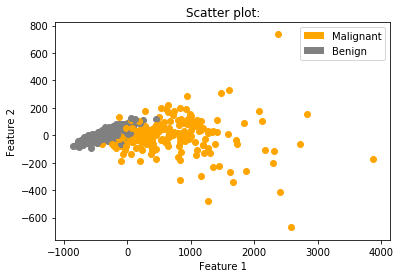

In [61]:
  
# # Dataset 1 read

completedata = pd.read_csv("./data/data.csv")
completedata.head()
completedata.loc[completedata.diagnosis == 'M', 'diagnosis'] = 1
completedata.loc[completedata.diagnosis == 'B', 'diagnosis'] = 0

train_XGA = completedata[["radius_se","texture_mean","perimeter_mean","perimeter_se","area_se","smoothness_se","compactness_worst","concavity_mean","concavity_worst","concave points_se","concave points_worst","symmetry_mean","symmetry_worst","fractal_dimension_mean"]]
train_YGA = completedata.diagnosis
data1_labels = completedata.diagnosis
data1 = completedata.drop(["id","Unnamed: 32","diagnosis"],axis=1)

train_Y = np.array(data1_labels)
train_X = np.array(data1)
train_YGA = np.array(train_YGA)
train_XGA = np.array(train_XGA)
train_X,train_Y,train_XGA,train_YGA = shuffle(train_X,train_Y,train_XGA,train_YGA)




pca = PCA(n_components=2)
scatter_X = pca.fit_transform(train_X)


classes = ['Malignant','Benign']
colours = ['orange','grey']
recs = []
#plt.xlim([-1000, 1000])
#plt.ylim([-5, 30])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot:")
for i in range(0,len(colours)):
    recs.append(pat.Rectangle((0,0),1,1,fc=colours[i]))

for i in range(0,len(scatter_X)):
    if((train_Y[i] == 1)):
        plt.scatter(scatter_X[i][0],scatter_X[i][1],c=colours[0])
    else:
        plt.scatter(scatter_X[i][0],scatter_X[i][1],c=colours[1])
plt.legend(recs,classes,loc='best')
plt.show()

#from sklearn.decomposition import PCA
#pca = PCA(n_components=25)


rotationforest : 

RotationForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=4, max_features=1.0, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10,
             n_features_per_subset=3, n_jobs=1, oob_score=False,
             random_state=False, rotation_algo='pca', verbose=0,
             warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95145631, 0.95145631, 0.95098039, 0.96078431, 0.94117647]))
('Average Accuracy K Fold: ', 0.9511707595659624)


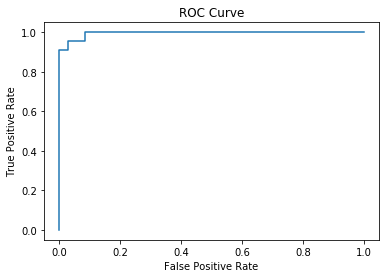

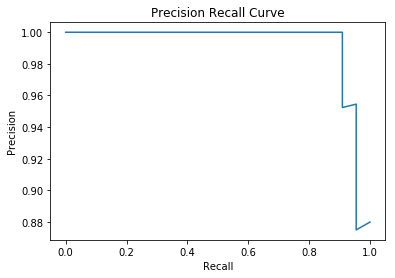

Test Data Results:
('Test Accuracy: ', 0.9649122807017544)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.91      0.95        22

   micro avg       0.96      0.96      0.96        57
   macro avg       0.97      0.95      0.96        57
weighted avg       0.97      0.96      0.96        57

ROC AUC 0.9948051948051948
('MCC: ', 0.9273353546322172)


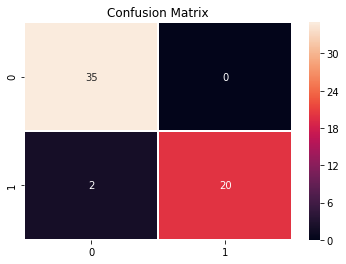

In [33]:
### features from paper
#print "=============================================================================="
print "\nrotationforest : \n"
reports(rotationforest,train_X,train_Y,0.1)


decisiontree : 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.93203883, 0.95145631, 0.95098039, 0.93137255, 0.91176471]))
('Average Accuracy K Fold: ', 0.9355225585379785)


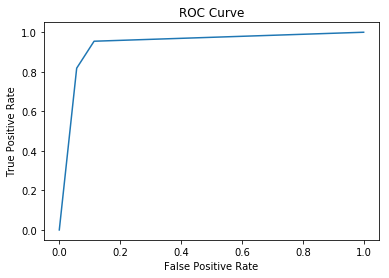

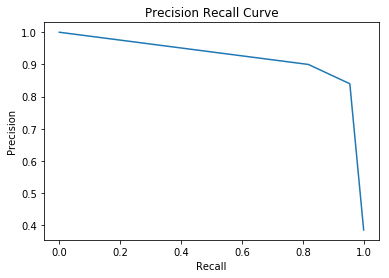

Test Data Results:
('Test Accuracy: ', 0.8947368421052632)
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.90      0.82      0.86        22

   micro avg       0.89      0.89      0.89        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.90      0.89      0.89        57

ROC AUC 0.9396103896103896
('MCC: ', 0.7763121683063989)


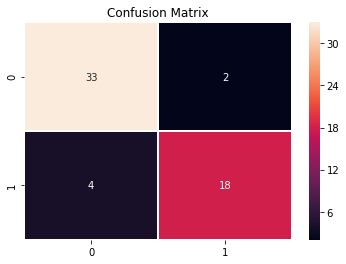

In [34]:
print "\ndecisiontree : \n"
reports(decisiontree,train_X,train_Y,0.1)


ann : 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.93203883, 0.97087379, 0.91176471, 0.93137255, 0.93137255]))
('Average Accuracy K Fold: ', 0.9354844850561583)


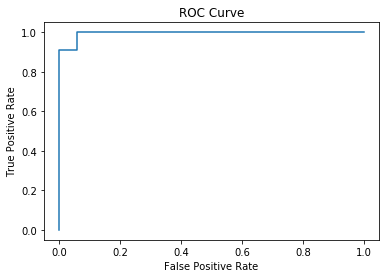

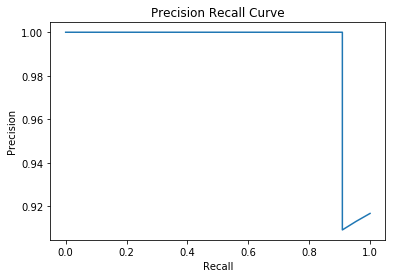

Test Data Results:
('Test Accuracy: ', 0.9298245614035088)
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.91      0.91      0.91        22

   micro avg       0.93      0.93      0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

ROC AUC 0.9948051948051948
('MCC: ', 0.8519480519480519)


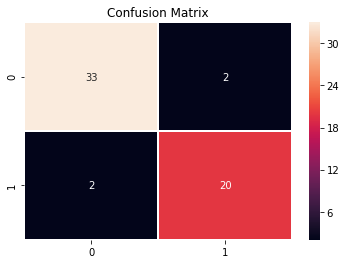

In [35]:
print "\nann : \n"
reports(ann,train_X,train_Y,0.1)


logistic regression : 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.96116505, 0.95145631, 0.93137255, 0.97058824, 0.93137255]))
('Average Accuracy K Fold: ', 0.9491909385113269)


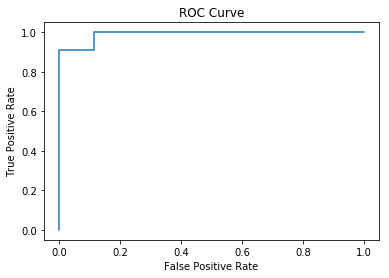

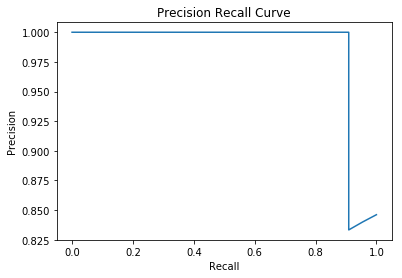

Test Data Results:
('Test Accuracy: ', 0.9473684210526315)
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.95      0.91      0.93        22

   micro avg       0.95      0.95      0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

ROC AUC 0.9896103896103896
('MCC: ', 0.8886350389948482)


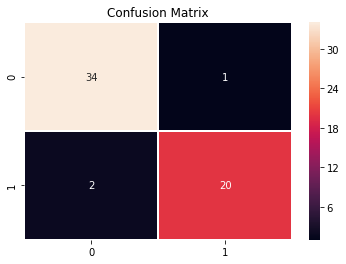

In [36]:
print "\nlogistic regression : \n"
reports(logistic,train_X,train_Y,0.1)


randomforest : 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.96116505, 0.98058252, 0.90196078, 0.96078431, 0.95098039]))
('Average Accuracy K Fold: ', 0.9510946126023224)


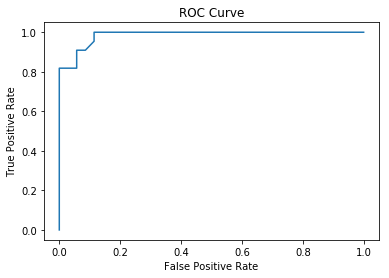

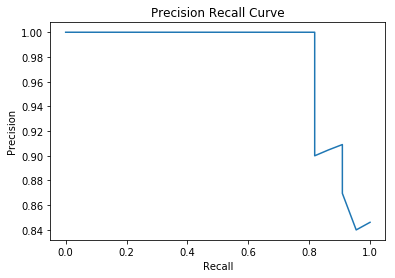

Test Data Results:
('Test Accuracy: ', 0.9298245614035088)
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.91      0.91      0.91        22

   micro avg       0.93      0.93      0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

ROC AUC 0.9850649350649351
('MCC: ', 0.8519480519480519)


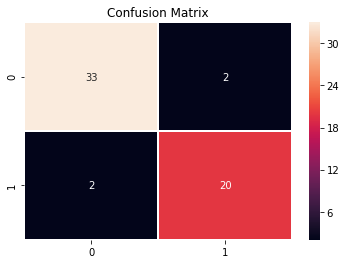

In [37]:
print "\nrandomforest : \n"
reports(randomforest,train_X,train_Y,0.1)


gausian : 

GaussianNB(priors=None, var_smoothing=1e-09)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.97087379, 0.97087379, 0.88235294, 0.97058824, 0.91176471]))
('Average Accuracy K Fold: ', 0.941290691033695)


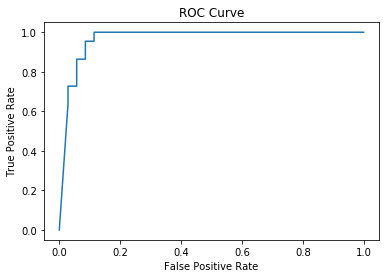

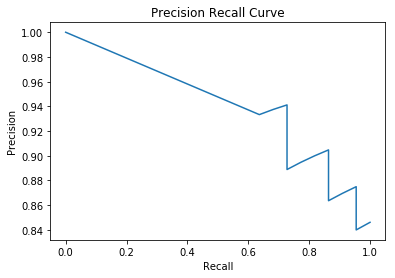

Test Data Results:
('Test Accuracy: ', 0.8947368421052632)
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.90      0.82      0.86        22

   micro avg       0.89      0.89      0.89        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.90      0.89      0.89        57

ROC AUC 0.9675324675324675
('MCC: ', 0.7763121683063989)


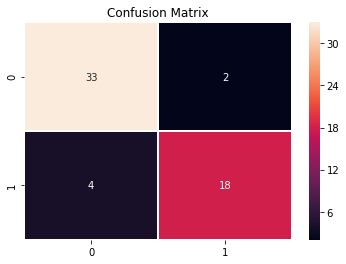

In [38]:
print "\ngausian : \n"
reports(gausian,train_X,train_Y,0.1)

In [39]:
print "\nsvm : \n"
reports_vote(sv,train_X,train_Y,0.1)


svm : 

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.9394631639063393)
Test Data Results:
('Test Accuracy: ', 1.0)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        22

   micro avg       1.00      1.00      1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

('MCC: ', 1.0)



knn : 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.91262136, 0.90291262, 0.89215686, 0.93137255, 0.91176471]))
('Average Accuracy K Fold: ', 0.9101656196459167)


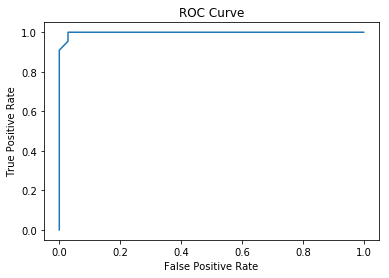

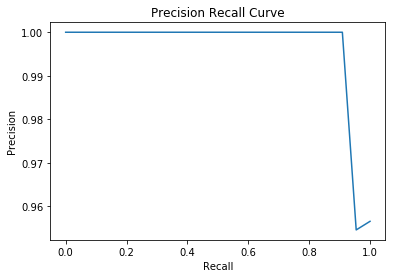

Test Data Results:
('Test Accuracy: ', 0.9473684210526315)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.86      0.93        22

   micro avg       0.95      0.95      0.95        57
   macro avg       0.96      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57

ROC AUC 0.9980519480519481
('MCC: ', 0.8918825850158447)


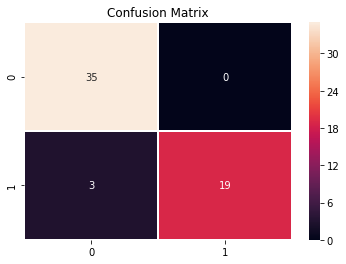

In [40]:
print "\nknn : \n"
reports(knn,train_X,train_Y,0.1)

In [41]:
print "\n Voting :\n"
reports_vote(vote,train_X,train_Y,0.1)


 Voting :

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.9570150390253189)
Test Data Results:
('Test Accuracy: ', 0.9298245614035088)
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.95      0.86      0.90        22

   micro avg       0.93      0.93      0.93        57
   macro avg       0.93      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57

('MCC: ', 0.851823761469308)



Genetic algo selected features classifiers :

rotationforest : 

RotationForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=4, max_features=1.0, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10,
             n_features_per_subset=3, n_jobs=1, oob_score=False,
             random_state=False, rotation_algo='pca', verbose=0,
             warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95145631, 0.98058252, 0.90196078, 0.97058824, 0.93137255]))
('Average Accuracy K Fold: ', 0.9471920807157815)


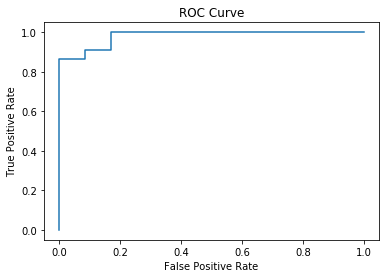

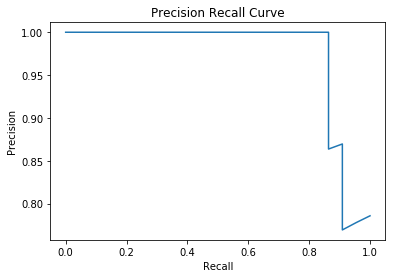

Test Data Results:
('Test Accuracy: ', 0.8947368421052632)
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.86      0.86      0.86        22

   micro avg       0.89      0.89      0.89        57
   macro avg       0.89      0.89      0.89        57
weighted avg       0.89      0.89      0.89        57

ROC AUC 0.9805194805194805
('MCC: ', 0.7779220779220779)


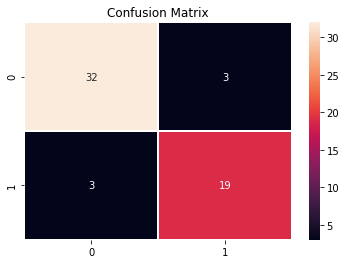

In [42]:
####genetic algo on data1
#print "Data 1 :"
#ga = FeatureSelectionGA(rotationforest,train_X,train_Y,cv_split=10)
#pop = ga.generate(100)

 ### report for selected features in paper
print "\nGenetic algo selected features classifiers :"
print "\nrotationforest : \n"
reports(rotationforest,train_XGA,train_YGA,0.1)


decisiontree : 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95145631, 0.96116505, 0.89215686, 0.92156863, 0.94117647]))
('Average Accuracy K Fold: ', 0.9335046640015229)


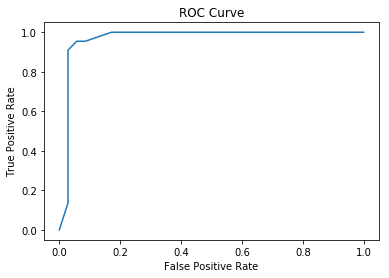

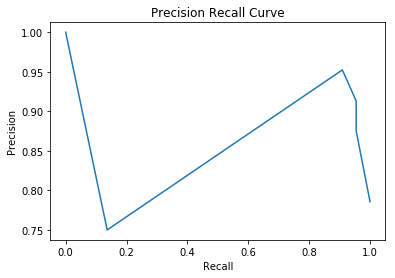

Test Data Results:
('Test Accuracy: ', 0.9473684210526315)
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.95      0.91      0.93        22

   micro avg       0.95      0.95      0.95        57
   macro avg       0.95      0.94      0.94        57
weighted avg       0.95      0.95      0.95        57

ROC AUC 0.9681818181818181
('MCC: ', 0.8886350389948482)


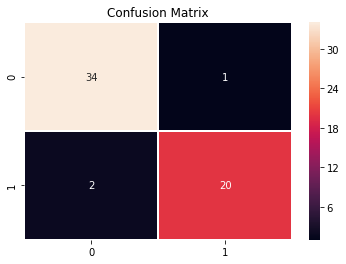

In [43]:
print "\ndecisiontree : \n"
reports(decisiontree,train_XGA,train_YGA,0.1)


ann : 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.90291262, 0.91262136, 0.87254902, 0.94117647, 0.90196078]))
('Average Accuracy K Fold: ', 0.9062440510184657)


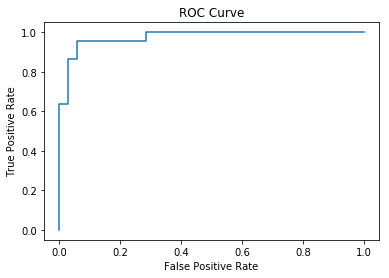

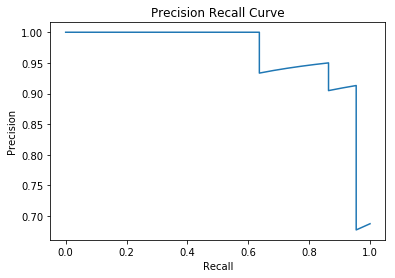

Test Data Results:
('Test Accuracy: ', 0.9122807017543859)
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.90      0.86      0.88        22

   micro avg       0.91      0.91      0.91        57
   macro avg       0.91      0.90      0.91        57
weighted avg       0.91      0.91      0.91        57

ROC AUC 0.9753246753246754
('MCC: ', 0.8139267835041308)


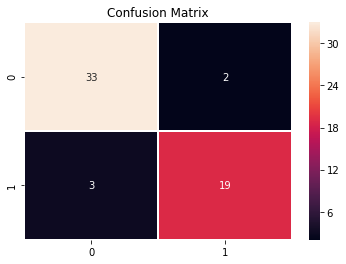

In [44]:
print "\nann : \n"
reports(ann,train_XGA,train_YGA,0.1)


logistic regression : 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.97087379, 0.95145631, 0.92156863, 0.98039216, 0.91176471]))
('Average Accuracy K Fold: ', 0.9472111174566914)


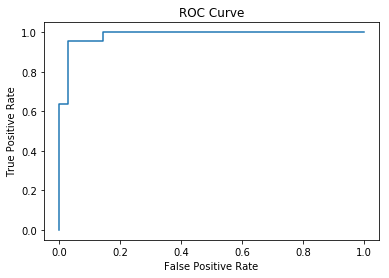

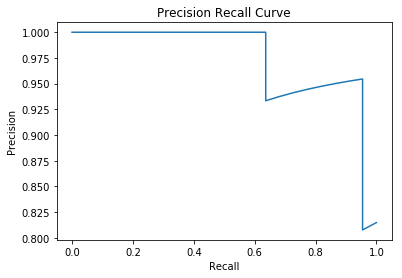

Test Data Results:
('Test Accuracy: ', 0.9649122807017544)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.95      0.95      0.95        22

   micro avg       0.96      0.96      0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57

ROC AUC 0.9844155844155844
('MCC: ', 0.925974025974026)


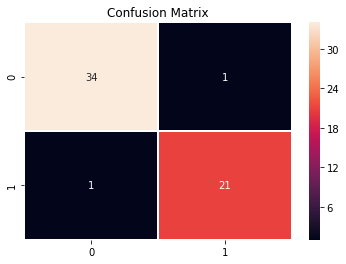

In [45]:
print "\nlogistic regression : \n"
reports(logistic,train_XGA,train_YGA,0.1)


randomforest : 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95145631, 0.96116505, 0.91176471, 0.96078431, 0.92156863]))
('Average Accuracy K Fold: ', 0.9413478012564249)


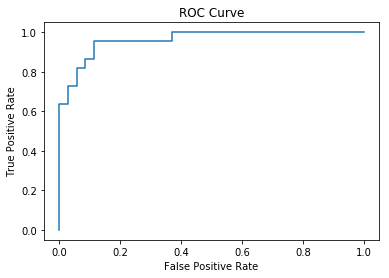

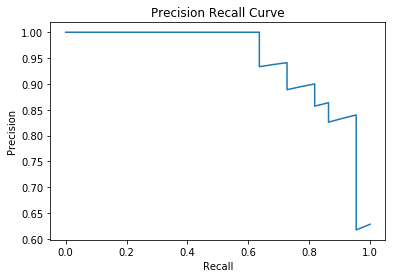

Test Data Results:
('Test Accuracy: ', 0.8947368421052632)
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        35
           1       0.90      0.82      0.86        22

   micro avg       0.89      0.89      0.89        57
   macro avg       0.90      0.88      0.89        57
weighted avg       0.90      0.89      0.89        57

ROC AUC 0.9610389610389611
('MCC: ', 0.7763121683063989)


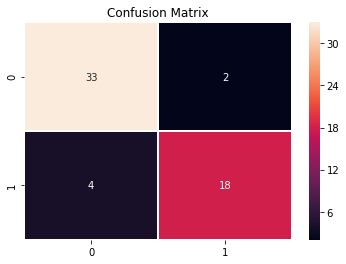

In [46]:
print "\nrandomforest : \n"
reports(randomforest,train_XGA,train_YGA,0.1)


gausian : 

GaussianNB(priors=None, var_smoothing=1e-09)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.93203883, 0.94174757, 0.88235294, 0.96078431, 0.90196078]))
('Average Accuracy K Fold: ', 0.9237768893965355)


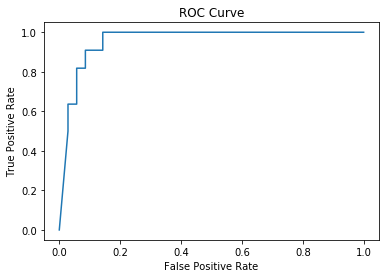

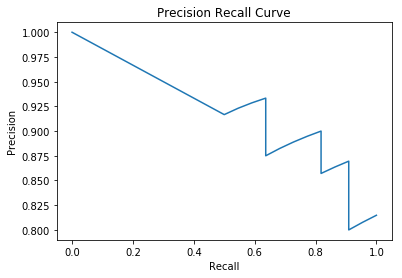

Test Data Results:
('Test Accuracy: ', 0.8771929824561403)
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.86      0.82      0.84        22

   micro avg       0.88      0.88      0.88        57
   macro avg       0.87      0.87      0.87        57
weighted avg       0.88      0.88      0.88        57

ROC AUC 0.9577922077922079
('MCC: ', 0.7392185280134135)


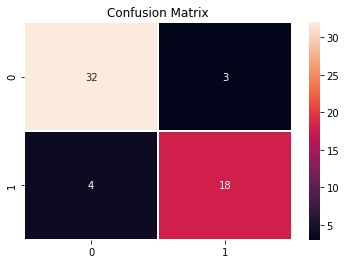

In [47]:
print "\ngausian : \n"
reports(gausian,train_XGA,train_YGA,0.1)

In [48]:
print "\nsvm : \n"
reports_vote(sv,train_XGA,train_YGA,0.1)


svm : 

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.90434037692747)
Test Data Results:
('Test Accuracy: ', 0.9122807017543859)
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.90      0.86      0.88        22

   micro avg       0.91      0.91      0.91        57
   macro avg       0.91      0.90      0.91        57
weighted avg       0.91      0.91      0.91        57

('MCC: ', 0.8139267835041308)



knn : 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.90291262, 0.90291262, 0.87254902, 0.94117647, 0.87254902]))
('Average Accuracy K Fold: ', 0.8984199505044735)


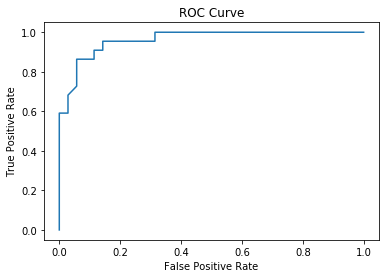

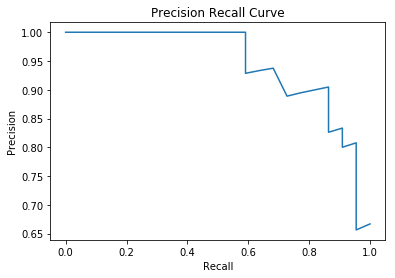

Test Data Results:
('Test Accuracy: ', 0.9122807017543859)
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.90      0.86      0.88        22

   micro avg       0.91      0.91      0.91        57
   macro avg       0.91      0.90      0.91        57
weighted avg       0.91      0.91      0.91        57

ROC AUC 0.9616883116883117
('MCC: ', 0.8139267835041308)


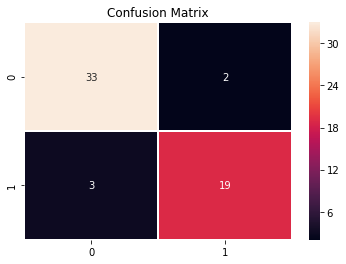

In [49]:
print "\nknn : \n"
reports(knn,train_XGA,train_YGA,0.1)

In [50]:
print "\n Voting :\n"
reports_vote(vote,train_XGA,train_YGA,0.1)


 Voting :

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.956957928802589)
Test Data Results:
('Test Accuracy: ', 0.9298245614035088)
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.91      0.91      0.91        22

   micro avg       0.93      0.93      0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

('MCC: ', 0.8519480519480519)


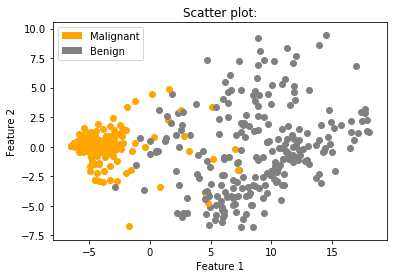

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [51]:
'''Dataset 2 working'''

data2 = np.genfromtxt("./data/breast-cancer-wisconsin.data",delimiter=",")
train_data2 = data2.T[1:].T
train_X2 = train_data2.T[0:-1].T.astype(float)
train_Y2 = train_data2.T[-1].T
for i in range(len(train_Y2)):
    if(train_Y2[i] == 2):
        train_Y2[i] = 1
    else:
        train_Y2[i] = 0
# print (train_Y2)
# print len(train_X2)
# print len(train_X2[0])
train_X2 = np.array(train_X2)
train_Y2 = np.array(train_Y2)
train_X2,train_Y2 = shuffle(train_X2,train_Y2)

plt.figure()
##########pca data visualization
pca = PCA(n_components=2)
scatter_X = pca.fit_transform(train_X2)


classes = ['Malignant','Benign']
colours = ['orange','grey']
recs = []
#plt.xlim([-5, 30])
#plt.ylim([-5, 30])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot:")
for i in range(0,len(colours)):
    recs.append(pat.Rectangle((0,0),1,1,fc=colours[i]))

for i in range(0,len(scatter_X)):
    if((train_Y2[i] == 1)):
        plt.scatter(scatter_X[i][0],scatter_X[i][1],c=colours[0])
    else:
        plt.scatter(scatter_X[i][0],scatter_X[i][1],c=colours[1])
plt.legend(recs,classes,loc='best')

plt.show()


# genetic algo
#print "Data 2 :"
#ga = FeatureSelectionGA(rotationforest,train_X2,train_Y2,cv_split=10)
#pop = ga.generate(50,mutxpb=0.4,ngen=6,cxpb=0.6)

print "+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"


rotationforest : 

RotationForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=4, max_features=1.0, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10,
             n_features_per_subset=3, n_jobs=1, oob_score=False,
             random_state=False, rotation_algo='pca', verbose=0,
             warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95934959, 0.98373984, 0.96747967, 0.96747967, 0.97540984]))
('Average Accuracy K Fold: ', 0.9706917233106758)


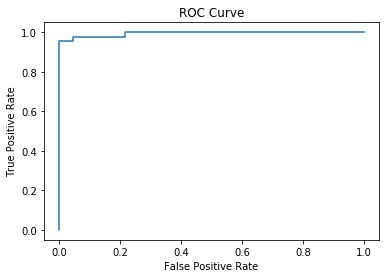

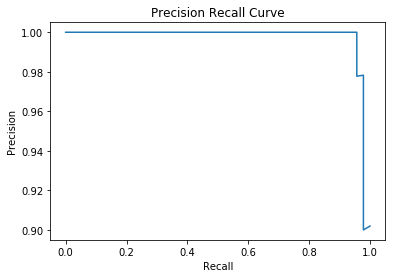

Test Data Results:
('Test Accuracy: ', 0.9710144927536232)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        23
         1.0       1.00      0.96      0.98        46

   micro avg       0.97      0.97      0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69

ROC AUC 0.9943289224952742
('MCC: ', 0.9380831519646858)


In [52]:
    
print "\nrotationforest : \n"
reportsData2(rotationforest,train_X2,train_Y2,0.1)


decisiontree : 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95934959, 0.93495935, 0.94308943, 0.94308943, 0.96721311]))
('Average Accuracy K Fold: ', 0.9495401839264292)


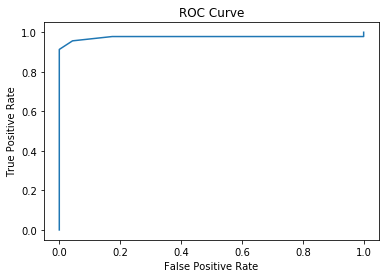

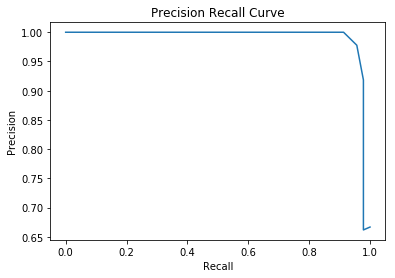

Test Data Results:
('Test Accuracy: ', 0.9565217391304348)
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        23
         1.0       0.98      0.96      0.97        46

   micro avg       0.96      0.96      0.96        69
   macro avg       0.95      0.96      0.95        69
weighted avg       0.96      0.96      0.96        69

ROC AUC 0.9749527410207941
('MCC: ', 0.903696114115064)


In [53]:
print "\ndecisiontree : \n"
reportsData2(decisiontree,train_X2,train_Y2,0.1)


 ann : 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.96747967, 0.96747967, 0.95934959, 0.94308943, 0.95081967]))
('Average Accuracy K Fold: ', 0.9576436092229775)


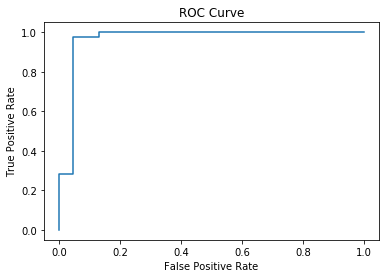

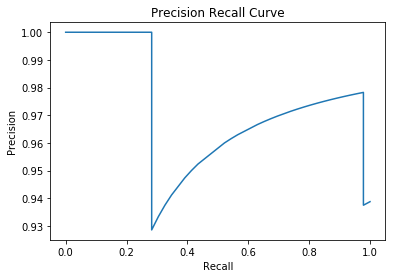

Test Data Results:
('Test Accuracy: ', 0.9565217391304348)
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        23
         1.0       0.96      0.98      0.97        46

   micro avg       0.96      0.96      0.96        69
   macro avg       0.96      0.95      0.95        69
weighted avg       0.96      0.96      0.96        69

ROC AUC 0.9669187145557656
('MCC: ', 0.901588969123762)


In [54]:
print "\n ann : \n"
reportsData2(ann,train_X2,train_Y2,0.1)


logistic regression : 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.96747967, 0.98373984, 0.96747967, 0.95121951, 0.95901639]))
('Average Accuracy K Fold: ', 0.965787018525923)


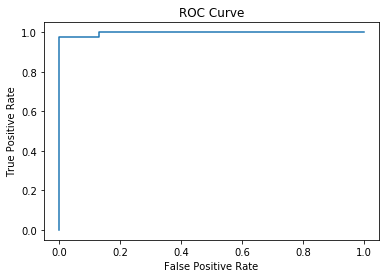

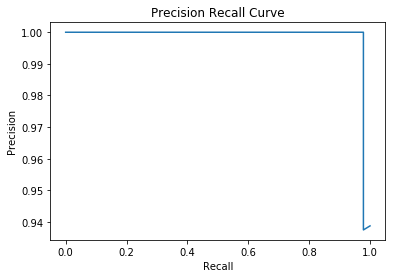

Test Data Results:
('Test Accuracy: ', 0.9855072463768116)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        23
         1.0       1.00      0.98      0.99        46

   micro avg       0.99      0.99      0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69

ROC AUC 0.997164461247637
('MCC: ', 0.9682458365518543)


In [55]:
print "\nlogistic regression : \n"
reportsData2(logistic,train_X2,train_Y2,0.1)


randomforest : 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.96747967, 0.98373984, 0.95934959, 0.94308943, 0.98360656]))
('Average Accuracy K Fold: ', 0.967453018792483)


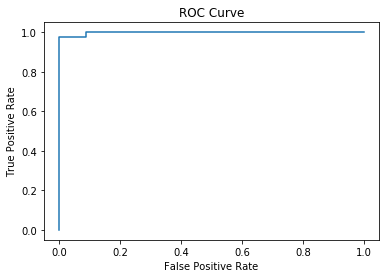

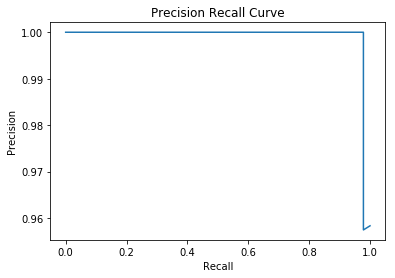

Test Data Results:
('Test Accuracy: ', 0.9710144927536232)
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        23
         1.0       0.98      0.98      0.98        46

   micro avg       0.97      0.97      0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

ROC AUC 0.998109640831758
('MCC: ', 0.9347826086956522)


In [56]:
print "\nrandomforest : \n"
reportsData2(randomforest,train_X2,train_Y2,0.1)


gausian : 

GaussianNB(priors=None, var_smoothing=1e-09)
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.95934959, 0.96747967, 0.95934959, 0.96747967, 0.95081967]))
('Average Accuracy K Fold: ', 0.9608956417433026)


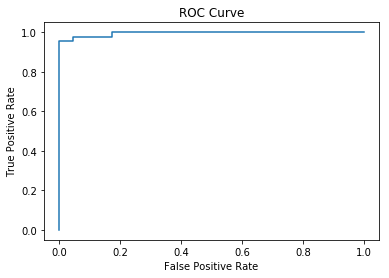

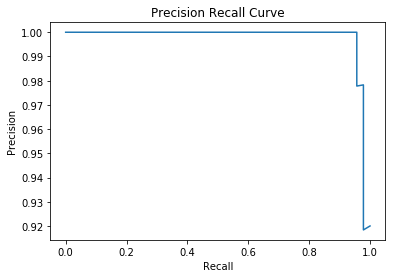

Test Data Results:
('Test Accuracy: ', 0.9710144927536232)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        23
         1.0       1.00      0.96      0.98        46

   micro avg       0.97      0.97      0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69

ROC AUC 0.995274102079395
('MCC: ', 0.9380831519646858)


In [57]:
print "\ngausian : \n"
reportsData2(gausian,train_X2,train_Y2,0.1)

In [58]:
print "\nsvm : \n"
reports_vote(sv,train_X2,train_Y2,0.1)


svm : 

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.9625216580034653)
Test Data Results:
('Test Accuracy: ', 0.9710144927536232)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        23
         1.0       1.00      0.96      0.98        46

   micro avg       0.97      0.97      0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69

('MCC: ', 0.9380831519646858)



Knn : 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')
KFold(n_splits=5, random_state=None, shuffle=False)
('Per fold Score 5 fold', array([0.98373984, 0.95934959, 0.95121951, 0.94308943, 0.95081967]))
('Average Accuracy K Fold: ', 0.9576436092229775)


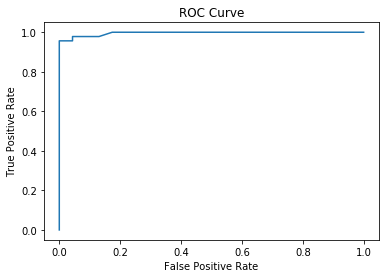

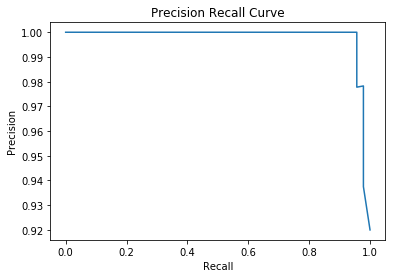

Test Data Results:
('Test Accuracy: ', 0.9710144927536232)
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        23
         1.0       0.98      0.98      0.98        46

   micro avg       0.97      0.97      0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

ROC AUC 0.9957466918714556
('MCC: ', 0.9347826086956522)


In [59]:
print "\nKnn : \n"
reportsData2(knn,train_X2,train_Y2,0.1)

In [60]:
print "\n Voting :\n"
reports_vote(vote,train_X2,train_Y2,0.1)


 Voting :

KFold(n_splits=5, random_state=None, shuffle=False)
('Average Accuracy K Fold: ', 0.9723177395708384)
Test Data Results:
('Test Accuracy: ', 0.9855072463768116)
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        23
         1.0       1.00      0.98      0.99        46

   micro avg       0.99      0.99      0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69

('MCC: ', 0.9682458365518543)
